Health Risk Assessment with BMI Categories

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


Step 1 – Load Dataset

In [4]:
df = pd.read_csv("500_Person_Gender_Height_Weight_Index.csv")
print("Dataset Sample:\n", df.head())

Dataset Sample:
    Gender  Height  Weight  Index
0    Male     174      96      4
1    Male     189      87      2
2  Female     185     110      4
3  Female     195     104      3
4    Male     149      61      3


Step 2 – Preprocessing

In [5]:
# Encode Gender (Male=1, Female=0)
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])

X = df[["Gender", "Height", "Weight"]].values
y = df["Index"].values  # 0-5 classes

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


Step 3 – Define Neural Network

In [6]:
class BMIClassifier(nn.Module):
    def __init__(self):
        super(BMIClassifier, self).__init__()
        self.fc1 = nn.Linear(3, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 6)  # 6 classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = BMIClassifier()

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Step 4 – Training

In [18]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 2000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [2000/10000], Loss: 0.0962
Epoch [4000/10000], Loss: 0.1011
Epoch [6000/10000], Loss: 0.0853
Epoch [8000/10000], Loss: 0.1036
Epoch [10000/10000], Loss: 0.0893


Step 5 – Evaluation

In [27]:
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()

print("\n✅ Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



✅ Model Evaluation:
Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.50      0.67         4
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0.93      0.96      0.94        26
           5       0.97      0.95      0.96        39

    accuracy                           0.95       100
   macro avg       0.92      0.90      0.89       100
weighted avg       0.96      0.95      0.95       100



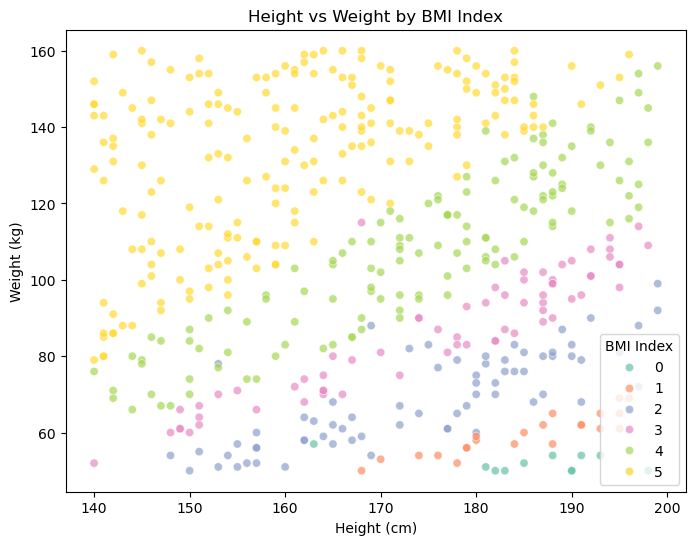

In [ ]:
# Height vs. Weight Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="Height", y="Weight", hue="Index", data=df, palette="Set2", alpha=0.7)
plt.title("Height vs Weight by BMI Index")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.legend(title="BMI Index")
plt.show()

Step 6 – Prediction on New Data

In [45]:
new_sample = np.array([[0, 160, 120]])  # FeMale, 170cm, 70kg
new_scaled = scaler.transform(new_sample)
new_tensor = torch.tensor(new_scaled, dtype=torch.float32)

with torch.no_grad():
    pred_class = torch.argmax(model(new_tensor)).item()

bmi_categories = {
    0: "Extremely Weak",
    1: "Weak",
    2: "Normal",
    3: "Overweight",
    4: "Obesity",
    5: "Extreme Obesity"
}

print(f"\n Predicted BMI Category for {new_sample}: {bmi_categories[pred_class]}")


 Predicted BMI Category for [[  0 160 120]]: Extreme Obesity
